# Double-slit correlation model

Based on Double Slit Model notebook, extended to model correlations with phase variation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sp
from numpy import pi, sin, cos, linspace, exp, real, imag, abs, conj, meshgrid, log, log10, angle, zeros, complex128, random
from numpy.fft import fft, fftshift, ifft
from mpl_toolkits.mplot3d import axes3d


import BeamOptics as bopt

In [2]:
%matplotlib inline

In [3]:
b=.08*1e-3  # the slit width
a=.5*1e-3  # the slit spacing
k=2*pi/(795*1e-9)  # longitudinal wavenumber
wt=0  # let time be zero
C=1  # unit amplitude
L=1.8  # distance from slits to CCD
d=.016  # distance from signal to LO at upstream end (used to calculate k_perp)
ccdwidth = 1300  # number of pixels
pixwidth = 20e-6  # pixel width (in meters)

y = linspace(-pixwidth*ccdwidth/2,pixwidth*ccdwidth/2,ccdwidth)

In [4]:
# define the various double slit fields and LO:

def alpha(y,a):
    return k*a*y/(2*L)

def beta(y,b):
    return k*b*y/(2*L)

def E_ds(y,a,b):
    """ Double-slit field """
    # From Hecht p 458:
    #return b*C*(sin(beta(y)) / beta(y)) * (sin(wt-k*L) + sin(wt-k*L+2*alpha(y)))
    # drop the time-dep term as it will average away:
    return 2*b*C*(sin(beta(y,b)) / beta(y,b)) * cos(alpha(y,a)) #* sin(wt - k*L + alpha(y))

def E_dg(y,a,b):
    """ Double gaussian field """
    # The width needs to be small enough to see interference
    # otherwise the beam doesn't diffract and shows no interference.
    # We're using b for the gaussian width (i.e. equal to the slit width)
    w=b
    #return C*exp(1j*k*0.1*d*y/L)
    return 5e-3*(bopt.gaussian_beam(0,y-a/2,L,E0=1,wavelambda=795e-9,w0=w,k=[0,0,k]) + 
              bopt.gaussian_beam(0,y+a/2,L,E0=1,wavelambda=795e-9,w0=w,k=[0,0,k]))

def E_lo(y,d):
    """Plane-wave LO beam incident at small angle, transverse wavenumber k*d*y/L"""
    return C*exp(-1j*k*d*y/L)

## Define a single function to explore the FFT:

In [5]:
def plotFFT(d,a,b):
    """Single function version of generating the FFT output"""
    TotalField = E_dg(y,a,b)+E_lo(y,d)
    TotalIntensity=TotalField*TotalField.conj()
    plt.plot(abs(fft(TotalIntensity)),".-")
    plt.ylim([0,1e-2])
    plt.xlim([0,650])
    plt.title("FFT output")

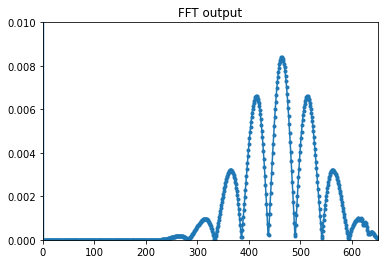

In [6]:
plotFFT(d=0.046,a=0.5e-3,b=0.08e-3)

### Replace with Gaussian LO: import gaussian beam function, and repeat:

In [7]:
# bopt.gaussian_beam(x, y, z, E0, wavelambda, w0, k)
# set to evaluate gaussian at L (full distance to CCD) with waist width of 2 cm
# using d=0.046 for agreement with experiment
d=0.046
E_lo_gauss = bopt.gaussian_beam(0,y,L,E0=1,wavelambda=795e-9,w0=0.02,k=[0,k*d/L,k])

In [28]:

frames = 59
rounds = 20

drift_type= 3
# SG I made a few drift modes to model the phase drift that would be present in the lab
# drift mode two appears to be the most similar to the phase shifts we observe in the lab

time=linspace(0,2*pi,rounds*frames)

phase=[]

if drift_type == 0:
    phase= [sin(t) for t in time]
#mode 0 is just a sine wave in time
    
elif drift_type == 1:
    phase= [sin(t+random.randn()/2) for t in time]
    #phase= [sin(t)+random.randn()/2 for t in time]
#mode 1 is a sine wave with some randomness added to each data point
    
elif drift_type == 2:
    phase=[0]
    for i in range(len(time)-1):
        phase.append(phase[-1]+random.randn()/4*sin(time[i]))
#mode 2 is a sine wave with some randomness added to each data point, and also considering
#the location of the previous data point
        
elif drift_type == 3:
    phase=[0]
    for i in range(len(time)-1):
        phase.append(phase[-1]+0.1*(random.randn()))
#mode 2 is a sine wave with some randomness added to each data point, and also considering
#the location of the previous data point
        
    


raw_intensity_data = zeros([1300,frames,rounds],dtype=complex128)
scaled = zeros([1300,frames,rounds],dtype=complex128)
i=0
for r in range(rounds):
    for f in range(frames):
        TotalField = E_dg(y,a,b)*exp(-1j*phase[i]) + E_lo_gauss #adds the appropriate phase
        #TotalField = E_dg(y,a,b) + E_lo_gauss
        TotalIntensity = TotalField * TotalField.conj()
        raw_intensity_data[:,f,r] = TotalIntensity
        scaled[:,f,r]=fft(TotalIntensity)
        i=i+1 #increases index      

Text(0.5, 1.0, 'phase shift with (simulated) time')

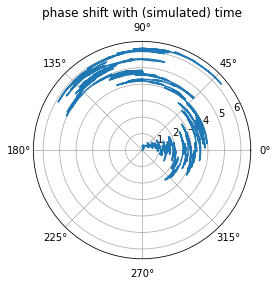

In [29]:
#checking how phase moves around
plt.polar(phase,time,'-')
plt.title("phase shift with (simulated) time")

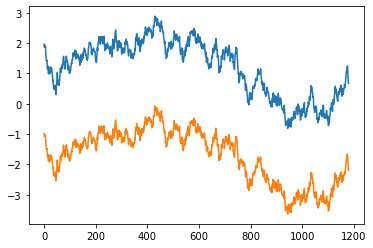

In [30]:
plt.plot((np.unwrap(angle(scaled[461,:,:].flatten("F")))))
plt.plot((np.unwrap(angle(scaled[470,:,:].flatten("F")))))
#plt.ylim(0,1e-2)
#TODO -unwrapping the phase (numpy)

(1300,)


(430.0, 500.0)

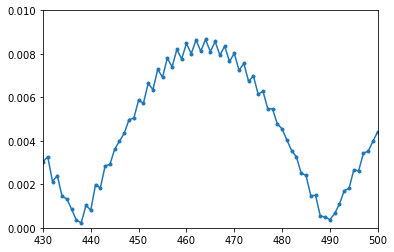

In [31]:
plt.plot(abs(fft(TotalIntensity)),".-")
print(TotalIntensity.shape)

plt.ylim([0,0.01]) # Had to lower the LO power quite a bit, and then zoom way in.

plt.xlim([430,500])

Adding different phase drifts to individual modes

original signal -> FFT -> 

In [32]:
mode_of_interest = 440
mode_offset = 300
range_to_analyze = 300
# Calculate the correlation matrix between phase of each mode.
modes = range(0,range_to_analyze)

PearsonPhase = np.zeros((range_to_analyze,range_to_analyze))

for m in modes:
    output = scaled[m+mode_offset,:,:].flatten('F')  # Choose the mode to analyze
    x = np.angle(output)
  
    for l in modes:
        #SG added np.unwrap call to the angle
        Pearson, p = sp.pearsonr(np.unwrap(np.angle(scaled[l+mode_offset].flatten('F'))), x)
        if (m==l):
            PearsonPhase[m,l] = 0 #AMCD Null the 1.0 auto-correlation
        else:
            PearsonPhase[m,l] = Pearson

<class 'numpy.ndarray'>
max value = 0.9999999872825857


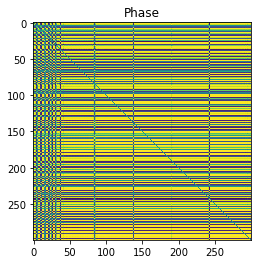

In [33]:
plt.imshow(PearsonPhase,interpolation='none')
plt.title("Phase")
print(type(PearsonPhase))
print("max value =",np.amax(PearsonPhase))

max value = 0.99999999965129


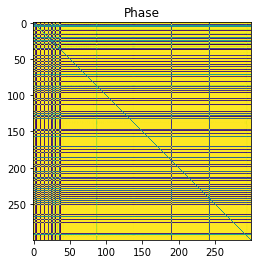

In [15]:
plt.imshow(PearsonPhase,interpolation='none')
plt.title("Phase")
print("max value =",np.amax(PearsonPhase))